# Optimization

In [2]:
import modules
import numpy as np
import importlib
importlib.reload(modules)
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from functools import partial

max_iter = 2000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(x0, x_name, p):
    cost_per_yield, price, fish_yield = modules.obj_terms(x0, x_name, p)
    print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')

def print_ineq_cons(x0, x_name, p):
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[0]), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[1]), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[2]), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[3]), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[4]), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[5]), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[6]), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[7]), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[8]), '[mg/l]')
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_bold("optimal objective function terms:")
    print_objective(res[opt_idx].x, x_name, p)
    print("-"*40)
    
    print_bold("optimal constraints:")
    print_ineq_cons(res[opt_idx].x, x_name, p)
    print("-"*40)
    
class OpObj(object):
    def __init__(self, x0, x_name, p):
        self.x_name, self.p = x_name, p
        self.x0 = x0
        self.f = np.full(shape=(max_iter+1,), fill_value=np.NaN)
        self.ineq = np.full(shape=(max_iter+1,len(modules.ineq_constraint(x0, x_name, p))), fill_value=np.NaN)
        self.eq = np.full(shape=(max_iter+1,0), fill_value=np.NaN)
        self.count = 0
        
    def obj_fun(self, x):
        return obj_fun(x, self.x_name, self.p)

def cb(xk, obj=None):
    obj.f[obj.count] = obj.obj_fun(xk)
    obj.ineq[obj.count] = modules.ineq_constraint(xk, x_name, p)
    obj.eq[obj.count] = modules.eq_constraint(xk, x_name, p)
    obj.count += 1

def obj_fun(x0, x_name, p):
    return modules.obj(x0, x_name, p)

# design variables
x_name = ['x_wec','x_pen'] #['x_env']
x_list = modules.variable_lookup(x_name)
x_list_default_values = modules.default_values(x_name)
x_list_bnds_values = modules.bnds_values(x_name)
x0 = []
x_unit = []
x_bnds = []
for i in range(len(x_list)):
    x0.append(x_list_default_values[x_list[i]][0])
    x_unit.append(x_list_default_values[x_list[i]][1])
    x_bnds.append(x_list_bnds_values[x_list[i]])

# parameters
wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

default_vars = []
for i in range(len(all_vars)):
    if all_vars[i] not in x_name:
        default_vars.append(all_vars[i])

p_list = modules.variable_lookup(default_vars)
p_list_default_values = modules.default_values(default_vars)
p = {}
p_unit = []
for i in range(len(p_list)):
    p[p_list[i]] = p_list_default_values[p_list[i]][0]
    p_unit.append(p_list_default_values[p_list[i]][1])

#optimization
best_idx = 0
res={}

for i in range(len(wec_types)):
    p['wec_type'] = wec_types[i]
             
    op_obj = OpObj(x0, x_name, p)    

    arguments = (x_name, p)

    print_bold("Initial objective function terms:")
    print_objective(x0, x_name, p)
    print_bold("Initial constraints:")
    print_ineq_cons(x0, x_name, p)
    print('+'*40)
    
    cons = []
    cons.append({'type': 'ineq', 
                 'fun': modules.ineq_constraint, 'args': arguments})
    
    # adding x_bounds as constrains for COBYLA
    for factor in range(len(x_bnds)):
        lower, upper = x_bnds[factor]
        l = {'type': 'ineq',
             'fun': lambda x, lb=lower, i=factor: x[i] - lb}
        u = {'type': 'ineq',
             'fun': lambda x, ub=upper, i=factor: ub - x[i]}
        cons.append(l)
        cons.append(u)

    options={"maxiter":max_iter}

    res[i] = minimize(obj_fun, op_obj.x0, 
                      args=arguments, 
                      method='COBYLA', 
                      #bounds=x_bnds, 
                      constraints=cons,
                      options=options,
                      callback=partial(cb, obj=op_obj))

    if res[i].fun < res[best_idx].fun:
        best_idx = i

optimize_result(x_name, x_list, x_unit, res, p, best_idx)

Initial objective function terms:
   cost_per_yield      0.625 [$/kg]
   price          601038.524 [$]
   fish_yield     961327.352 [kg]
Initial constraints:
   P_gen_cons           -14157.008 [kWh]
   fish_yield_cons       51011.584 [kg]
   env_Umin_cons             0.100 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons         12.000 [C]
   env_salinitymin_cons      3.000 [PSU]
   env_salinitymax_cons      2.000 [PSU]
   env_O2_min_cons           3.590 [mg/l]
++++++++++++++++++++++++++++++++++++++++
True
optimal design variable:
   capture_width      11.928 [m]
   pen_diameter       19.830 [m]
   pen_height          6.567 [m]
   spacing           150.730 [m]
   stock_density      30.000 [kg/m^3]
   pen_depth          10.055 [m]
----------------------------------------
optimal objective function terms:
   cost_per_yield      0.524 [$/kg]
   price          487987.871 [$]
   fish_yield     930970.890 [kg]
-------------------------

# Plot fish growth and fish oxygen demand

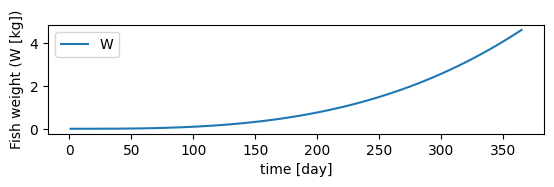

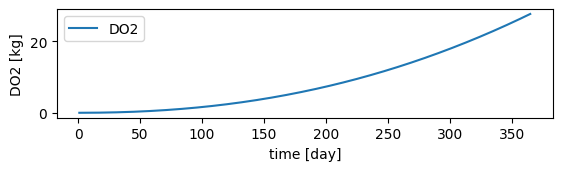

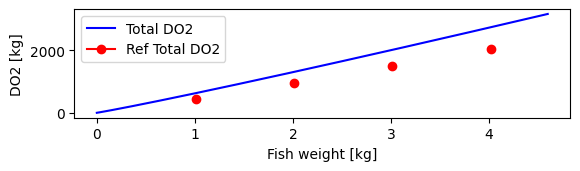

In [3]:
x_opt = res[best_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

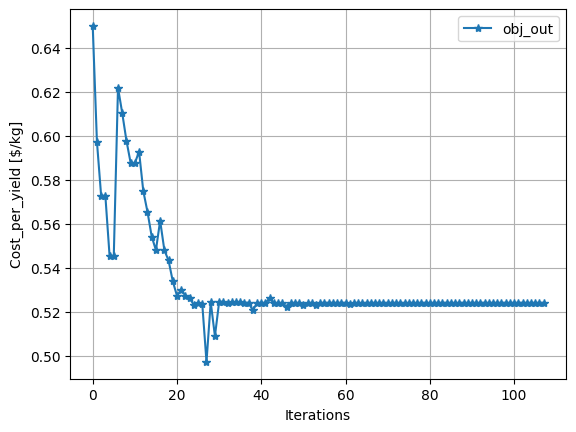

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

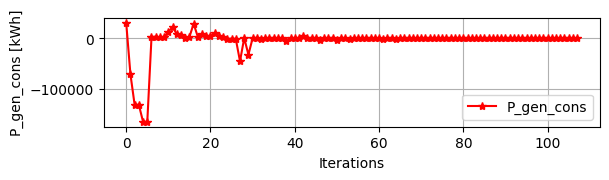

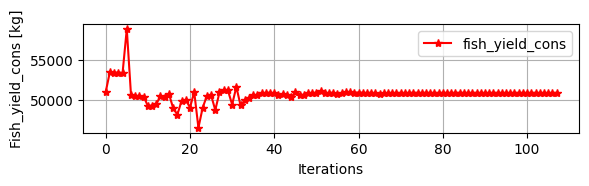

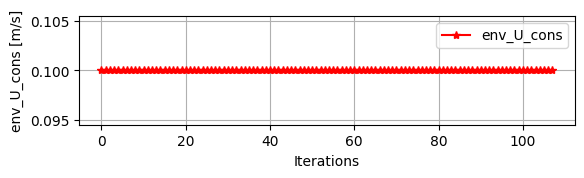

In [5]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()

ax3 = plt.subplot(3,1,3)
ax3.plot(op_obj.ineq[:, 2], 'r', label='env_U_cons', marker='*')
ax3.set(xlabel='Iterations', ylabel='env_U_cons [m/s]');
ax3.legend()
ax3.grid(True)
plt.show()

# Plot fitness 